<a href="https://colab.research.google.com/github/alvarofpinheiro/pifwia_abc/blob/main/PIFWIA_ABC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ABC - Artificial Bee Colony ou Colônia Artificial de Abelhas é um método proposto pelo pesquisador Derviş Karaboğa em 2005 para resolver problemas de otimização inspirado no comportamento do forrageamento inteligente das abelhas, buscando melhorar a solução candidata em relação a um objetivo.

In [ ]:
#instalar biblioteca Orange Canvas
!pip install Orange3

In [ ]:
#bibliotecas
from numpy.random import choice
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib.animation import FuncAnimation
import Orange

In [ ]:
#hiperparâmetros
DIMENSOES = 6 #determina a quantidade de dimensões do problema
ITERACOES = 200 #quantiddade máxima de ciclos defindo quantas explorações serão feitas (episódios)
ENXAME = 10 #tamanho da população correspondente ao número de abelhas na colônia
FONTES_ALIMENTACAO = int(ENXAME/2) #(nf) número de fontes de alimento que a colônia irá explorar (i.e., qtde de abelhas exploradoras) que é a metade da qtde de abelhas trabalhadoras
E1 = -100 #extremos 1 e 3
E2 = 100 #extremos 2 e 4
LIMITES = [E1,E2] #(bound) determina os valores maximos e minimos do espaço de busca (área de busca de fontes de alimentação)
CICLOS = 10 #(limite) qtde de ciclos sem melhora na exploração de uma fonte de alimento utilizado para abandonar essa exploração e buscar outras fontes aleatoriamente
FCUSTO = 'parábola' #(fitness) função custo que pode ser uma 'esfera' ou 'parábola' ou outra função custo que defina a densidade de alimentação das abelhas na área de busca
ABELHAS = [] #(swarm) array da criação das abelhas

In [ ]:
#importação dos dados
from google.colab import files  
files.upload()

In [ ]:
#criação do objeto de dados com base no caminho gerado com a importação do arquivo
dados = Orange.data.Table("/content/dados.csv")

In [ ]:
#exploração dos metadados da base de dados importada
qtde_campos = len(dados.domain.attributes)
qtde_cont = sum(1 for a in dados.domain.attributes if a.is_continuous)
qtde_disc = sum(1 for a in dados.domain.attributes if a.is_discrete)
print("%d metadados: %d continuos, %d discretos" % (qtde_campos, qtde_cont, qtde_disc))
print("Nome dos metadados:", ", ".join(dados.domain.attributes[i].name for i in range(qtde_campos)),)
#exploração dos domínios dos atributos (campos da base de dados)
dados.domain.attributes
#exploração dos dados (quantidade de registros da base de dados)
print("Qtde de Registros:", len(dados))
#exibição dos 5 primeiros registros para análise dos dados importados
i = 0
for d in dados[:10]:
  i += 1
  print(i, d)

In [ ]:
#criação dos arrays das dimensões do problema
#complexidade
#1 = muito baixa complexidade
#2 = baixa complexidade
#3 = média complexidade
#4 = alta complexidade
#5 = muito alta complexidade
periodo = []
complexidade = []
pagina = []
prazo = []
revisao = []
entrega = []
i = 0
for d in dados[:ENXAME]:
  periodo.append(d[1])
  complexidade.append(d[2])
  pagina.append(d[3])
  prazo.append(d[4])
  revisao.append(d[5])
  entrega.append(d[6])
  print("id:",i+1,"período:",periodo[i],"complexidade:",complexidade[i],"página:",pagina[i],"prazo:",prazo[i],"revisões:",revisao[i],"entrega:",entrega[i])

In [ ]:
#abelha - unidade base da otimização, posicionada numa determinada posição no espaço de busca do problema, representando uma solução em potencial para o problema
#(exploration) responsáveis por sair da colméia em busca de uma fonte de alimento para que de posse da informação da qualidade da fonte (fitness) retornam para repassar a informação
class Exploradora:
  def __init__(self):
        self.posicao = None
        self.trabalhadoras = []
        self.ciclos_sem_melhora = 0
#(exploitation) escolhem uma fonte de alimento para explorar de acordo com seu fitness, sendo as responsáveis por explorar a vizinhança de uma fonte de alimento
class Trabalhadora:
  def __init__(self):
        self.posicao = None

In [ ]:
#função fitness ou objetivo ou otimização - usada para verificação se o mínimo global está dentro de uma função custo determinada pelo argumento
def custo(posicao): 
  return sum([coord ** 2 for coord in posicao])
def fitness(problema, posicoes):
  total = 0.0
  if problema == 'esfera':
    for i in range(DIMENSOES):
      total += posicoes[i]**2
  elif problema == 'parábola':
    for i in range(DIMENSOES-1):
      total += 100*(posicoes[i+1] - posicoes[i]**2)**2 + (1-posicoes[i])**2
  elif problema == 'custo':
    for i in range(DIMENSOES-1):
      total += 1 / abs(custo(posicoes))
  else:
    print('Problema não encontrado!')
  return total

In [ ]:
#inicialização da população (enxame)
exploradoras = []
trabalhadoras = []
for i in range(FONTES_ALIMENTACAO):
  exploradora = Exploradora()
  for j in range(DIMENSOES):
  exploradora.posicao = [random.uniform(E1,E2), random.uniform(E1, E2)]
  exploradora.melhor_posicao = exploradora.posicao.copy()
  exploradoras.append(exploradora)
  trabalhadora = Trabalhadora()
  trabalhadoras.append(trabalhadora)
ABELHAS = exploradoras + trabalhadoras

Plano Cartesiano


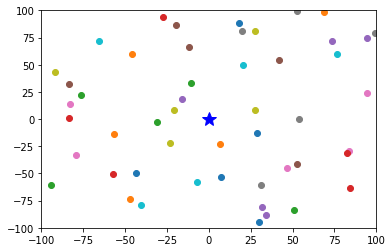

In [ ]:
#posições iniciais das abelhas exploradoras
print("Plano Cartesiano")
plt.axis([E1, E2, E1, E2])
plt.plot(0,0, marker='*', markersize=15, color='b')
for i in range(FONTES_ALIMENTACAO):
    abelha = exploradoras[i]
    #variáveis das DIMENSÕES do problema
    d1,d2 = zip(abelha.posicao)
    plt.plot(d1,d2, marker='o')
plt.show()

In [ ]:
#escolha das fontes de alimento
def alocar_abelhas(abelhas):
  #faz a soma dos fitness das abelhas exploradoras
  soma_fitness = 0
  for i in range(FONTES_ALIMENTACAO):
    soma_fitness += fitness(FCUSTO, exploradoras[i].posicao)
  #cria a distribuição de probabilidades de acordo com o fitness calculado
  distribuicao_probabilidade = []
  for i in range(FONTES_ALIMENTACAO):
    probabilidade_alocacao = fitness(FCUSTO, exploradoras[i].posicao) / soma_fitness
    distribuicao_probabilidade.append(probabilidade_alocacao)
  #posiciona as oportunitas de acordo com a atratividade das exploradoras, "transformando-as" agora em trabalhadoras
  for abelha in abelhas:
    exploradora = choice(exploradoras, 1, p=distribuicao_probabilidade)[0]
    abelha.posicao = exploradora.posicao.copy()
    exploradora.trabalhadoras.append(abelha)

In [ ]:
#movimentação da abelha exploradora
def movimenta_abelha(abelha):
  colonia_candidata = ABELHAS.copy()
  colonia_candidata.remove(abelha)
  abelha_candidata = random.choice(colonia_candidata)
  x = abelha.posicao[0] + random.uniform(-1, 1) * (abelha.posicao[0] - abelha_candidata.posicao[0])
  y = abelha.posicao[1] + random.uniform(-1, 1) * (abelha.posicao[1] - abelha_candidata.posicao[1])
  if x < -10:
    x = -10
  elif x > 10:
    x = 10
  if y < -10:
    y = -10
  elif y > 10:
    y = 10
  if fitness(FCUSTO, [x, y]) > fitness(FCUSTO, abelha.posicao):
    abelha.posicao = [x, y]

Iteração: 1


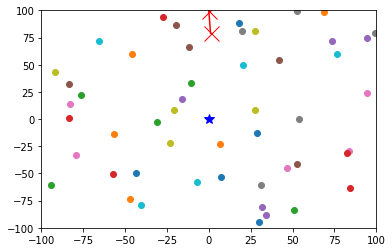

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 2


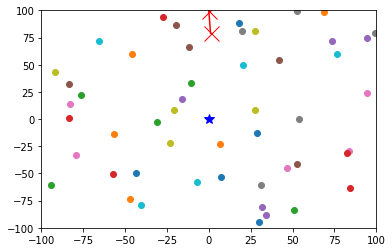

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 3


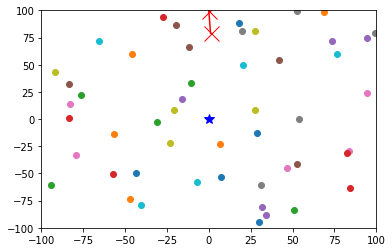

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 4


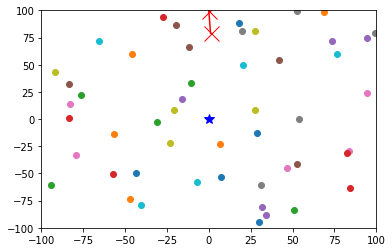

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 5


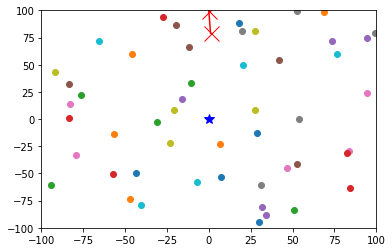

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 6


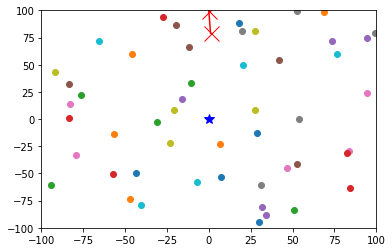

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 7


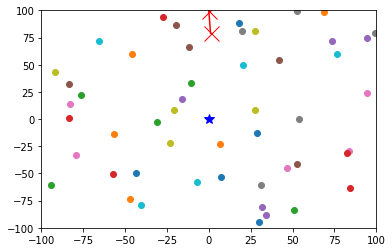

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 8


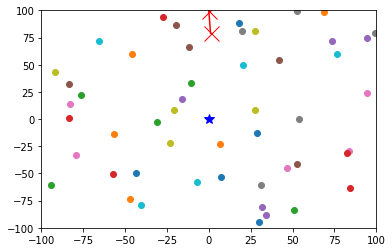

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 9


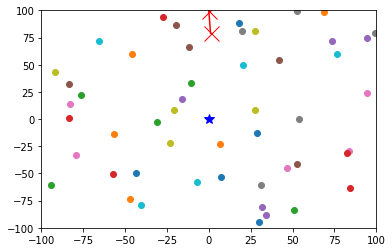

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 10


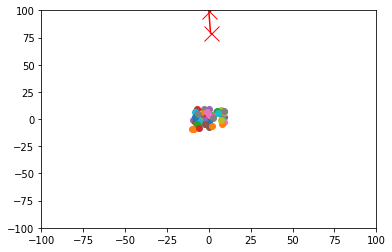

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 11


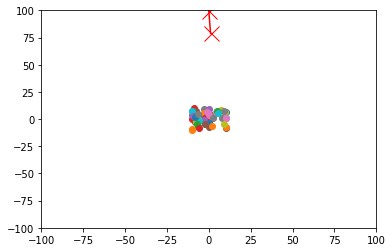

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 12


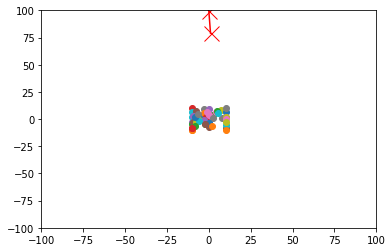

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 13


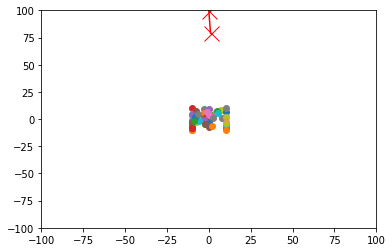

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 14


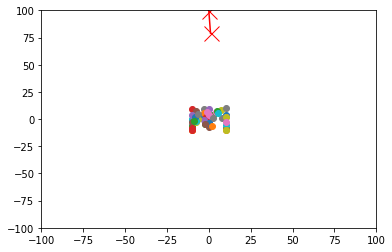

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 15


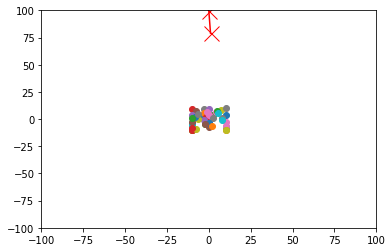

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 16


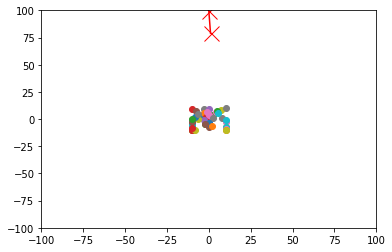

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 17


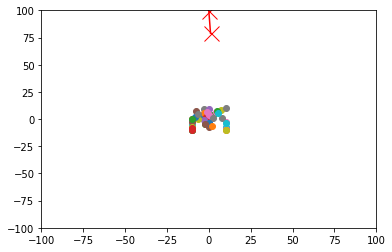

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 18


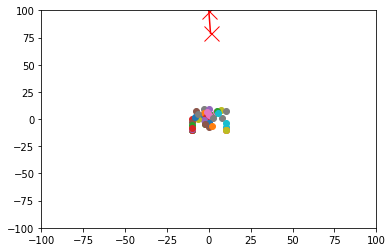

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 19


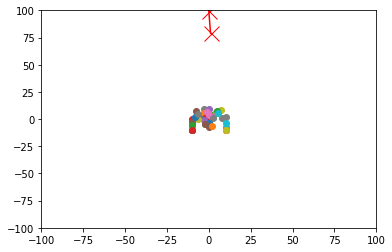

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 20


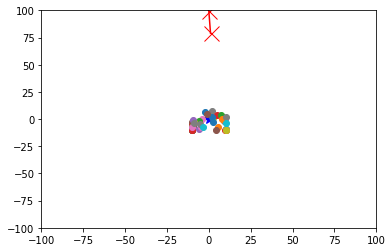

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 21


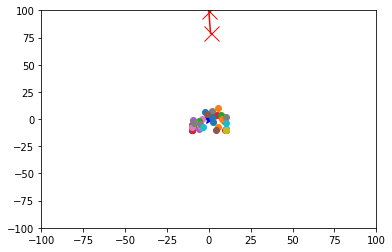

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 22


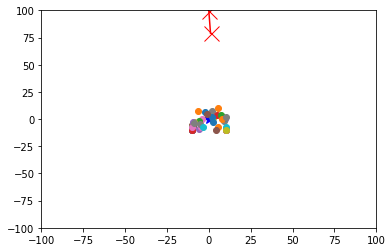

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 23


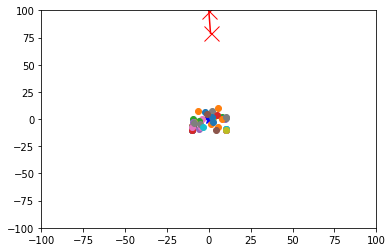

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 24


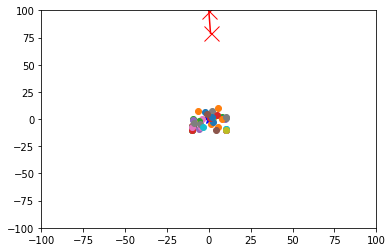

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 25


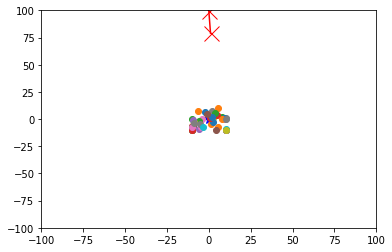

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 26


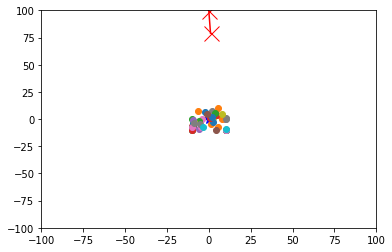

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 27


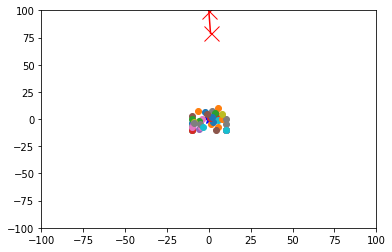

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 28


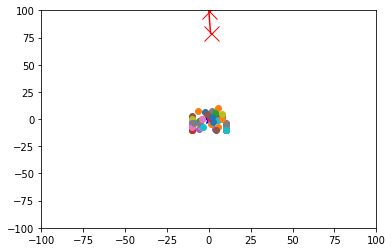

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 29


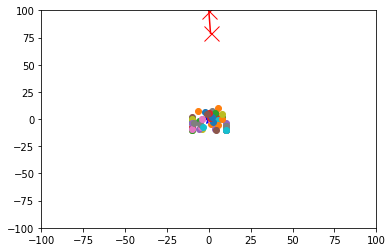

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 30


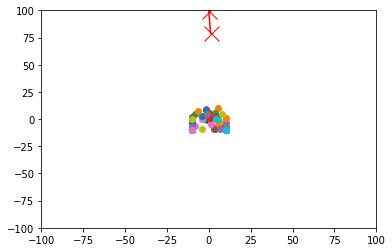

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 31


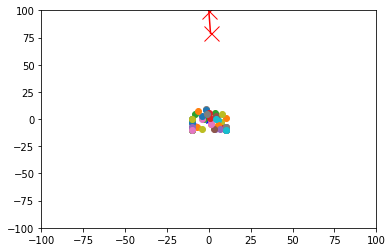

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 32


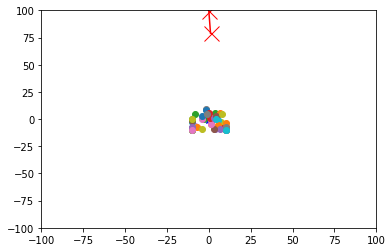

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 33


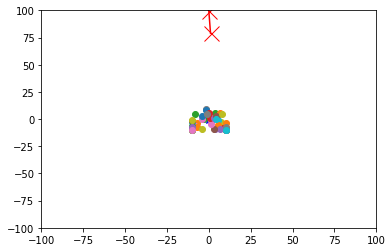

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 34


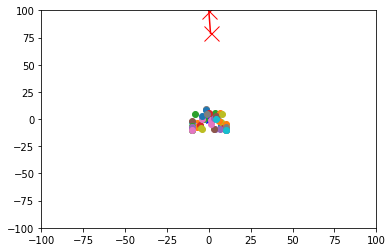

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 35


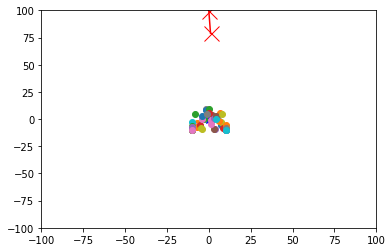

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 36


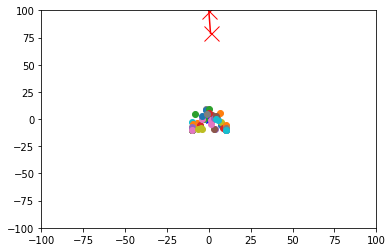

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 37


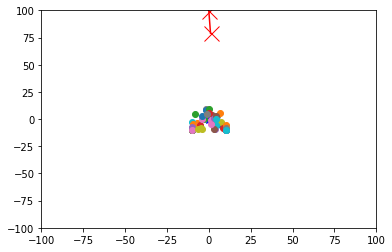

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 38


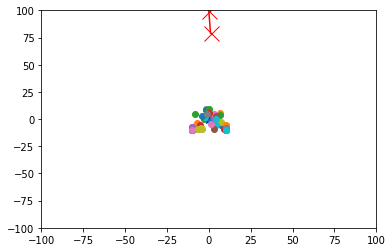

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 39


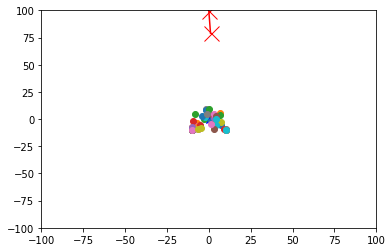

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 40


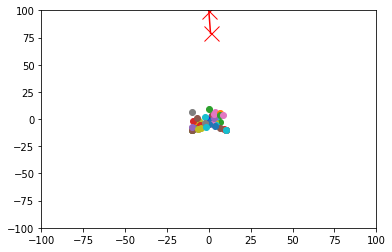

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 41


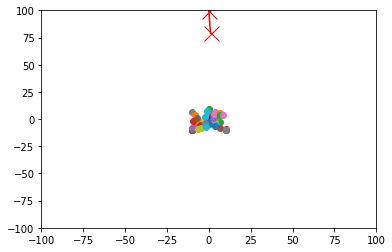

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 42


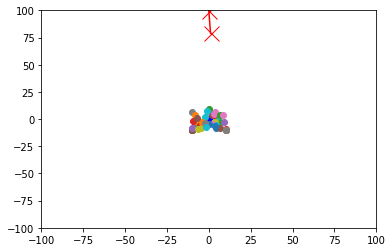

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 43


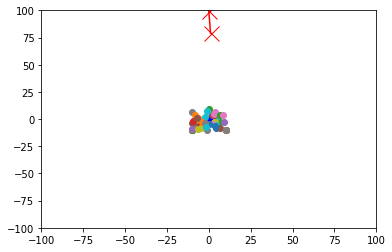

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 44


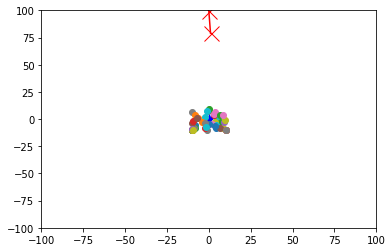

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 45


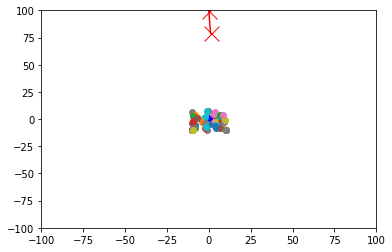

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 46


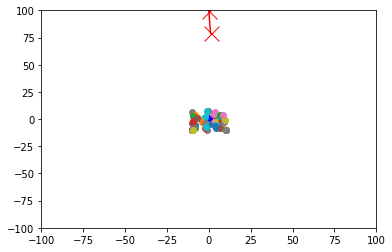

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 47


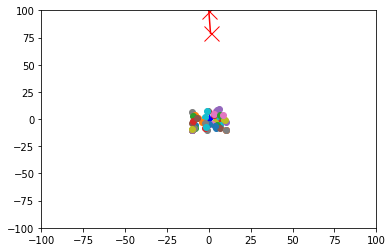

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 48


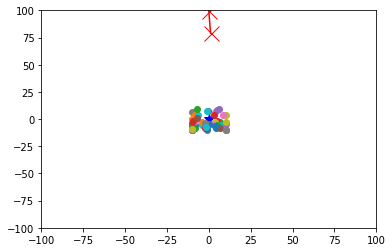

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 49


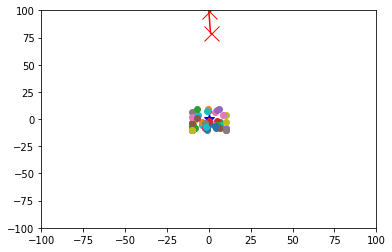

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 50


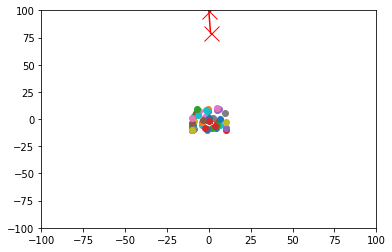

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 51


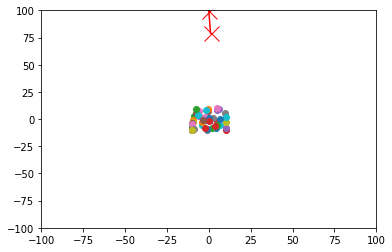

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 52


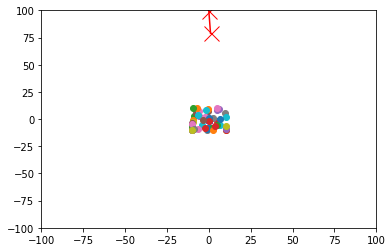

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 53


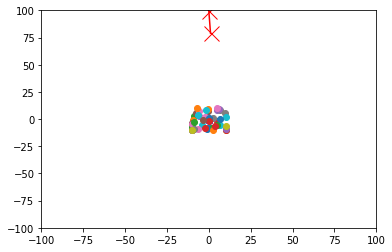

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 54


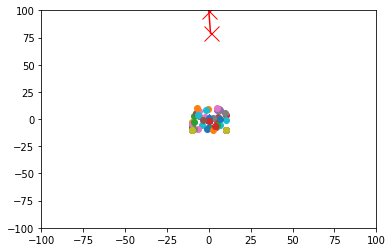

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 55


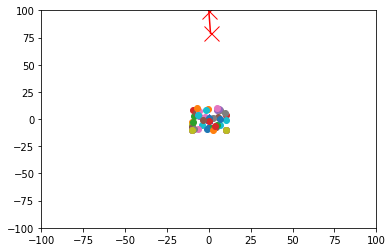

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 56


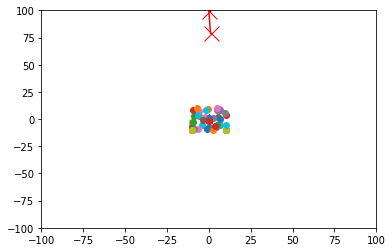

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 57


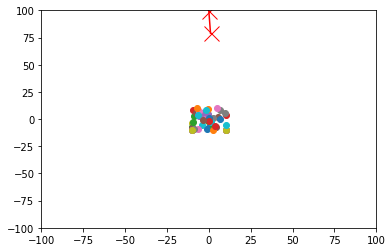

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 58


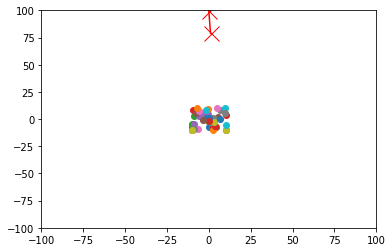

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 59


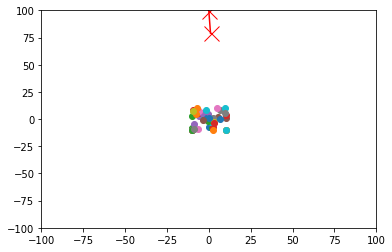

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 60


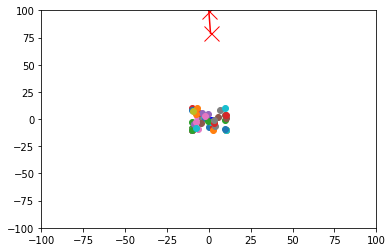

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 61


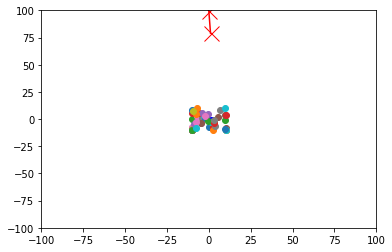

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 62


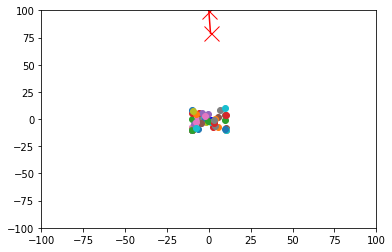

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 63


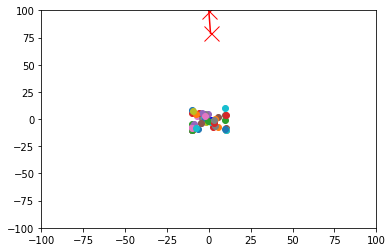

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 64


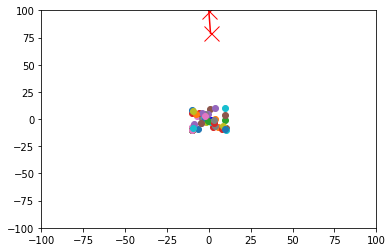

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 65


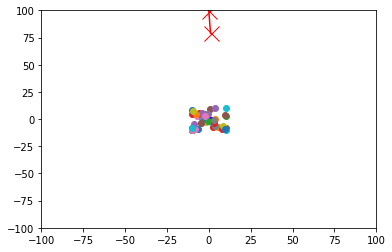

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 66


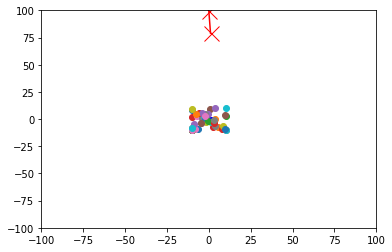

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 67


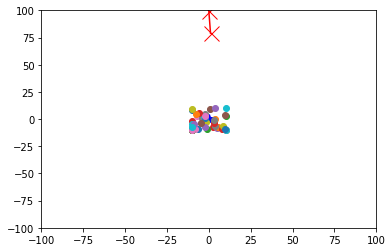

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 68


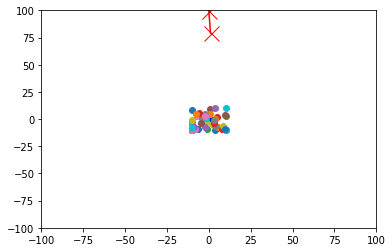

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 69


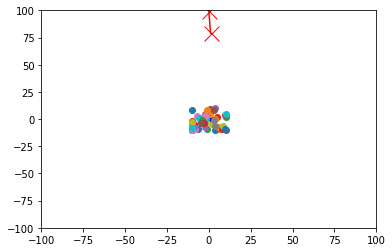

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 70


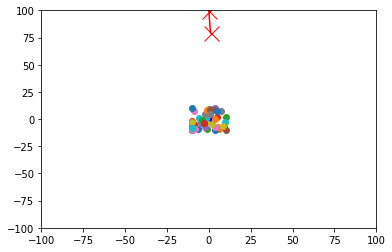

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 71


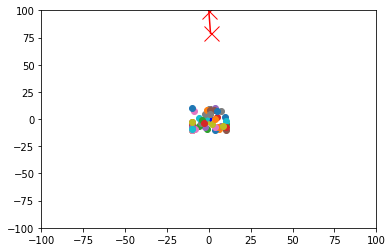

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 72


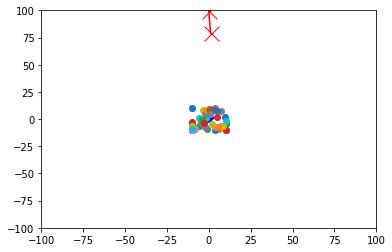

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 73


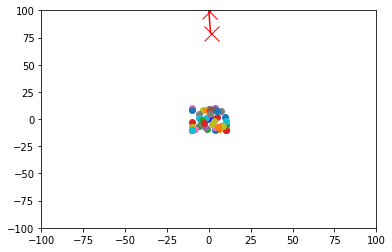

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 74


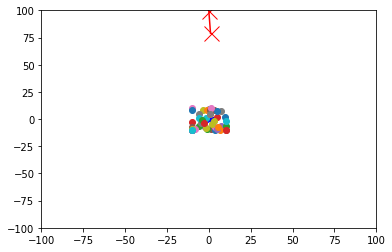

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 75


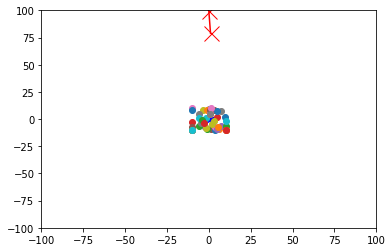

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 76


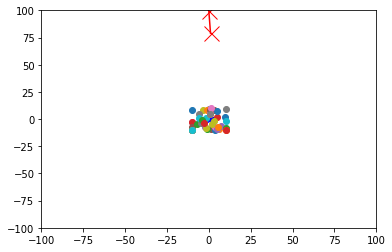

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 77


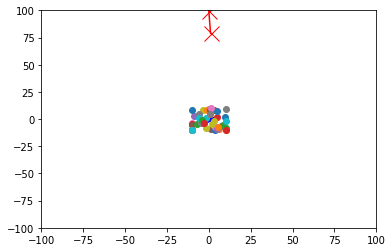

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 78


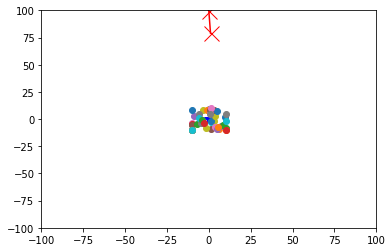

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 79


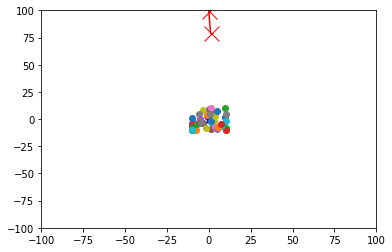

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 80


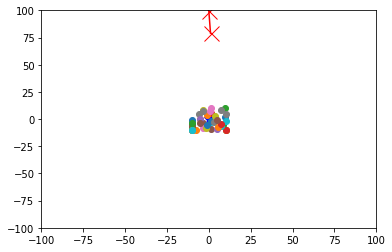

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 81


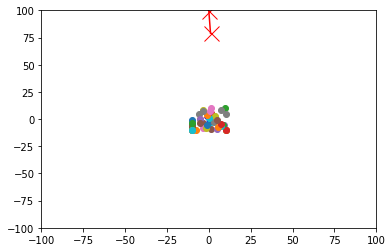

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 82


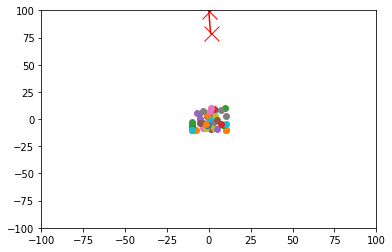

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 83


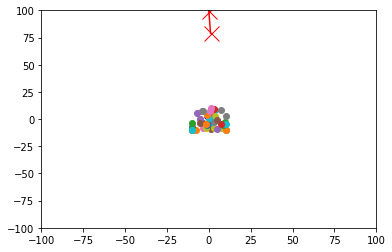

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 84


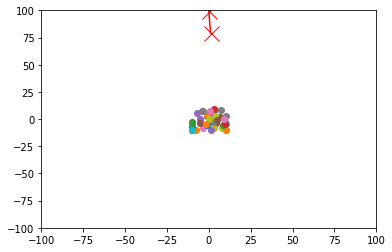

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 85


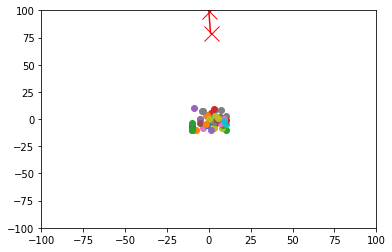

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 86


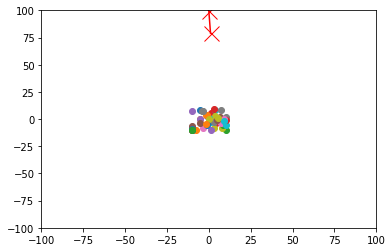

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 87


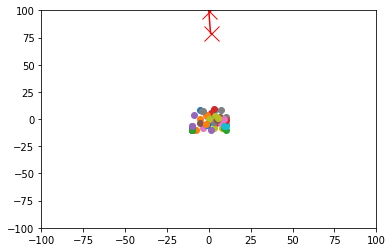

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 88


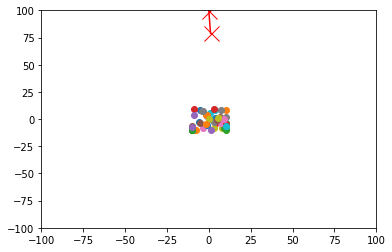

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 89


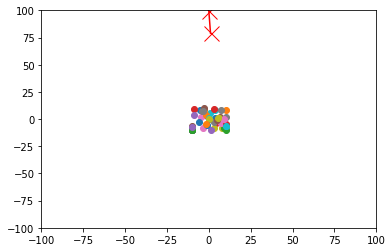

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 90


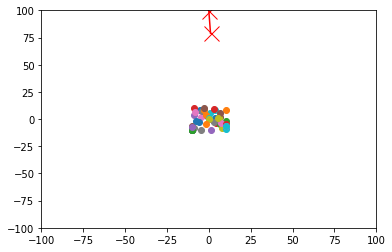

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 91


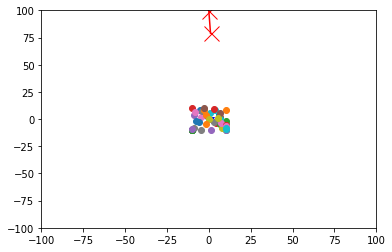

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 92


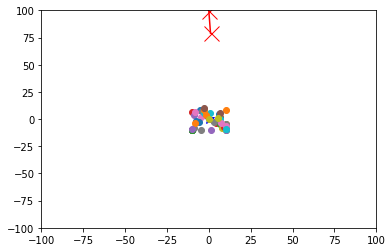

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 93


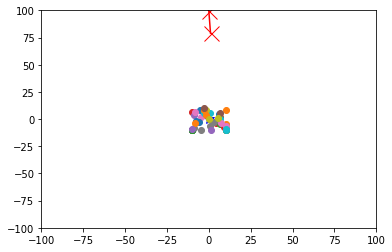

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 94


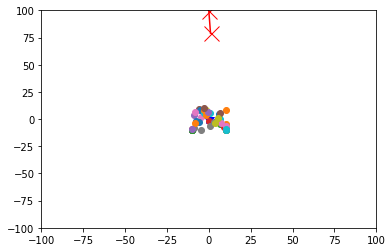

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 95


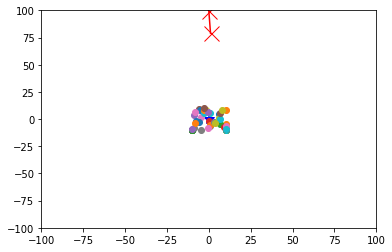

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 96


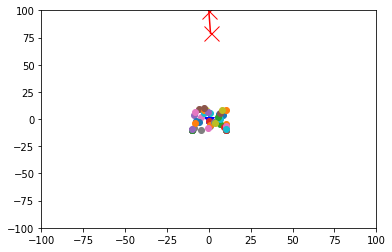

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 97


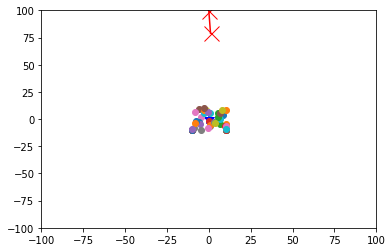

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 98


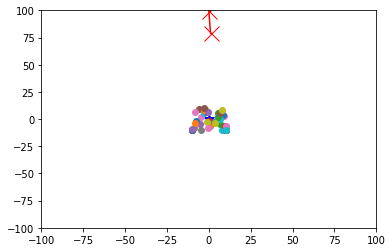

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 99


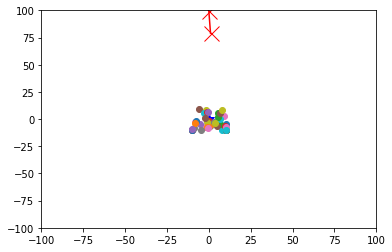

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 100


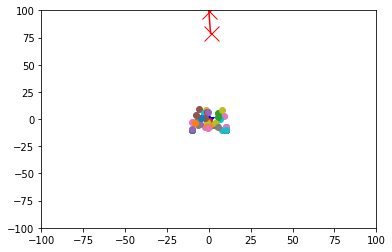

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 101


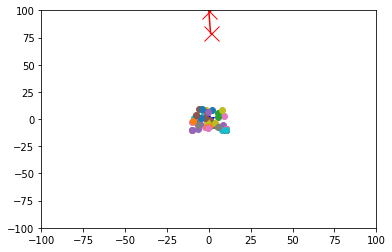

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 102


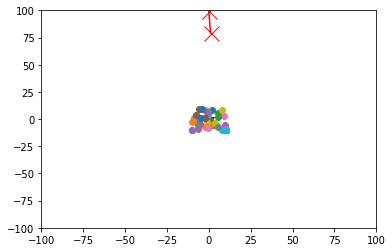

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 103


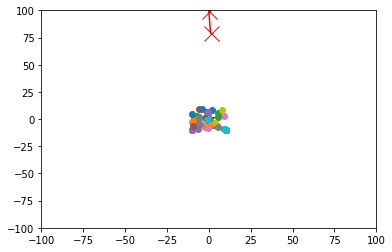

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 104


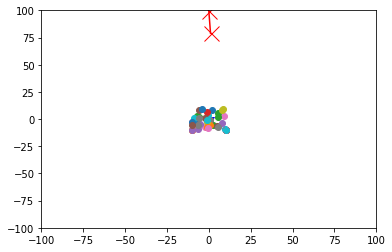

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 105


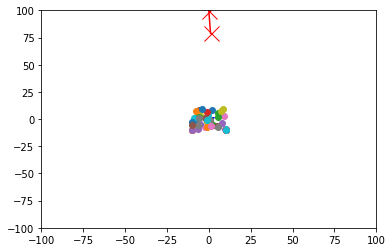

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 106


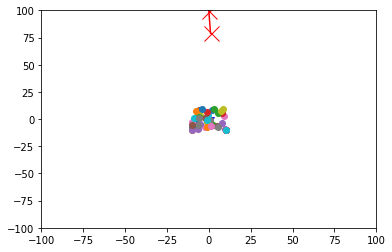

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 107


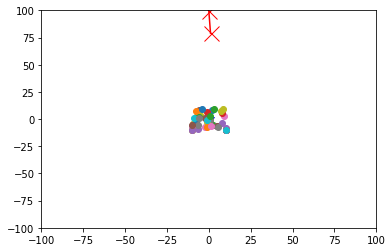

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 108


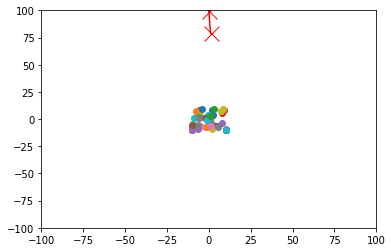

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 109


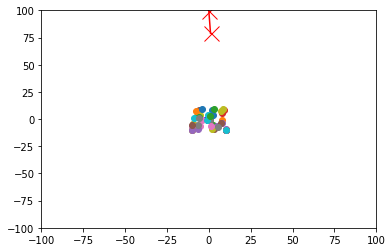

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 110


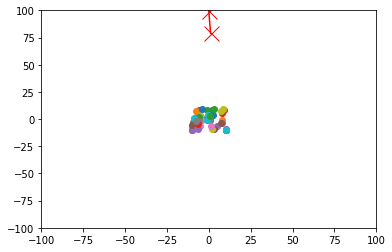

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 111


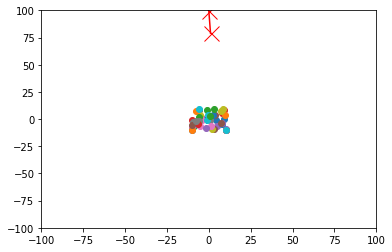

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 112


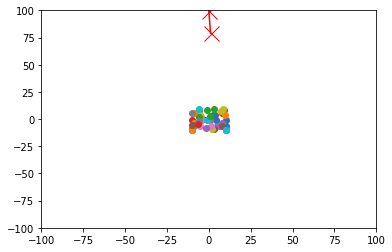

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 113


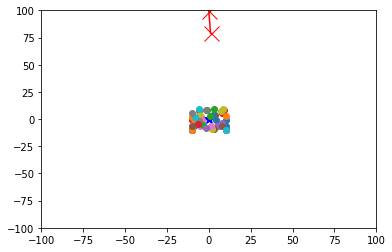

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 114


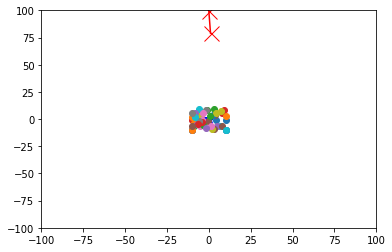

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 115


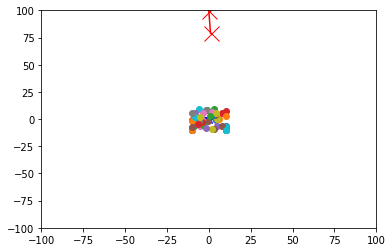

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 116


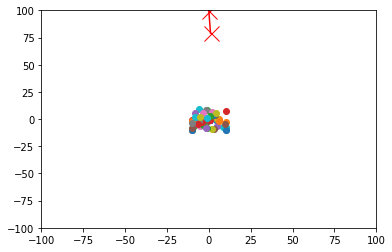

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 117


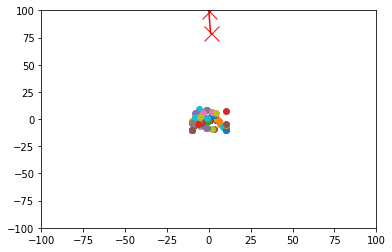

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 118


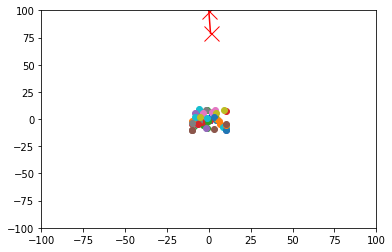

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 119


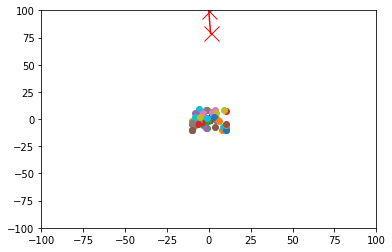

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 120


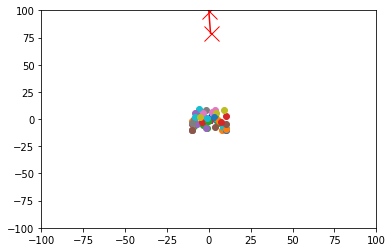

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 121


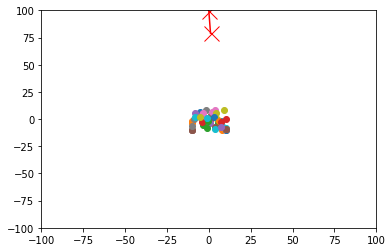

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 122


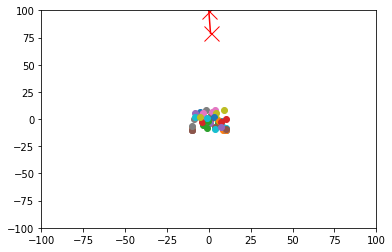

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 123


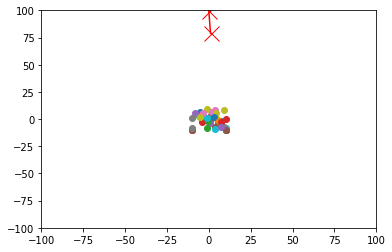

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 124


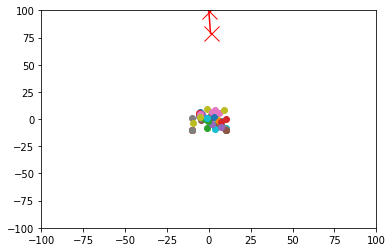

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 125


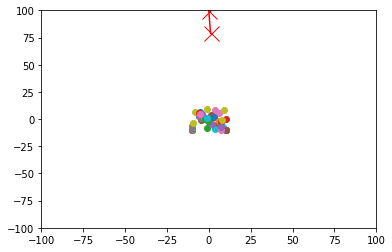

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 126


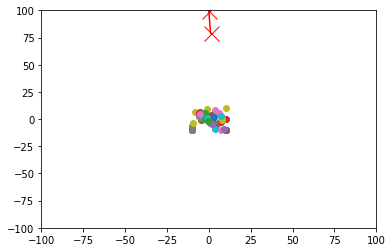

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 127


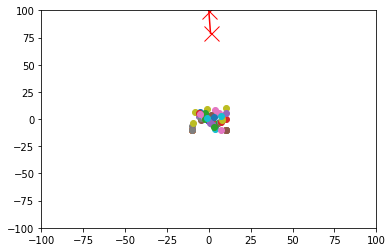

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 128


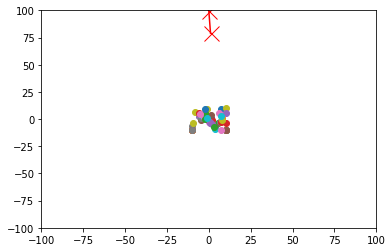

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 129


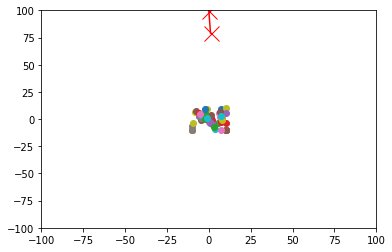

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 130


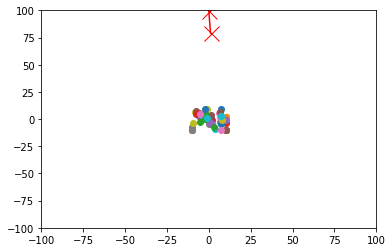

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 131


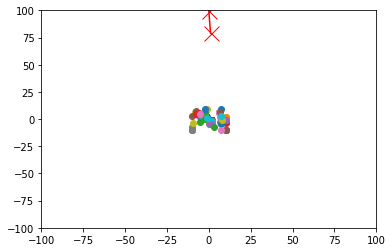

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 132


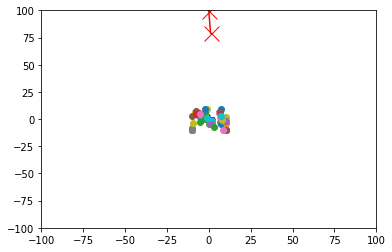

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 133


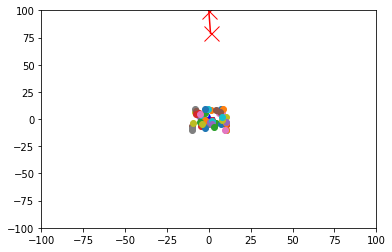

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 134


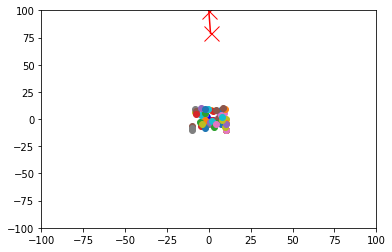

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 135


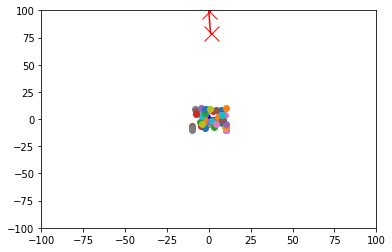

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 136


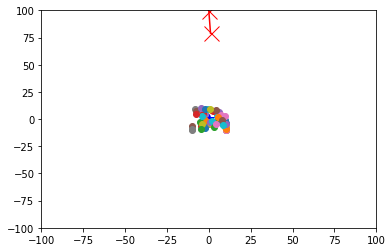

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 137


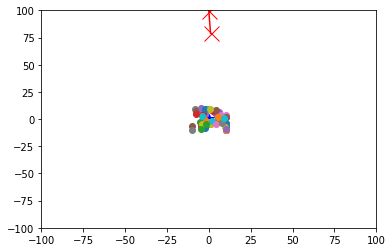

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 138


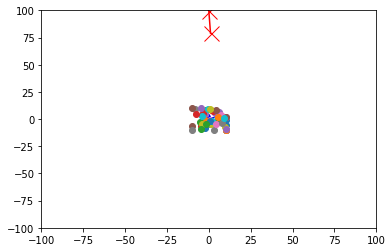

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 139


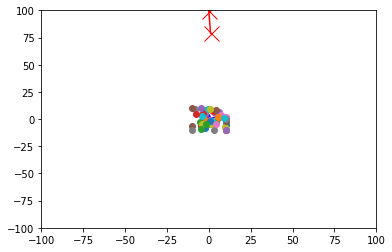

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 140


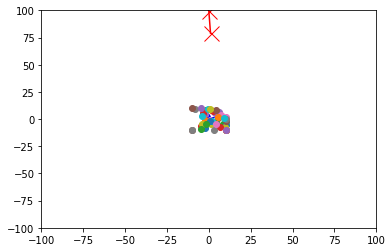

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 141


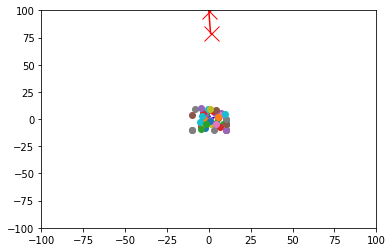

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 142


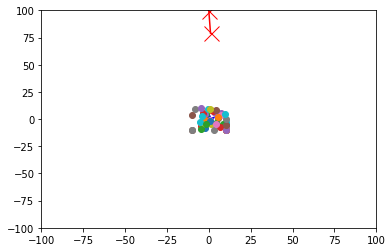

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 143


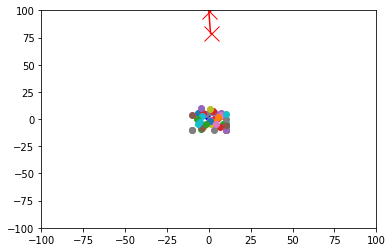

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 144


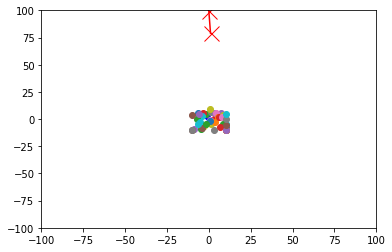

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 145


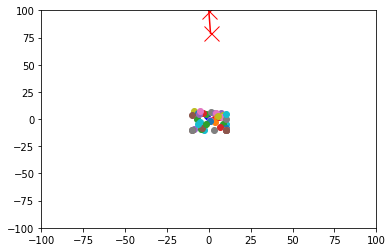

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 146


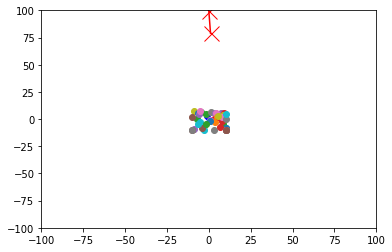

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 147


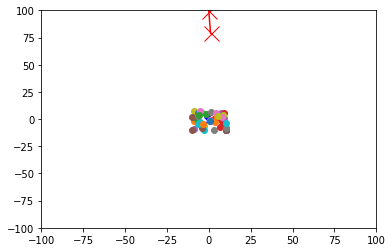

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 148


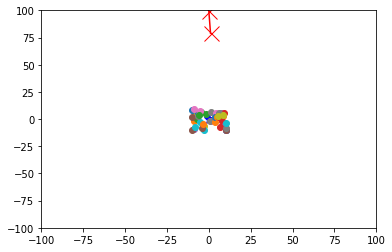

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 149


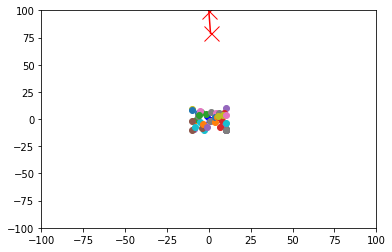

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 150


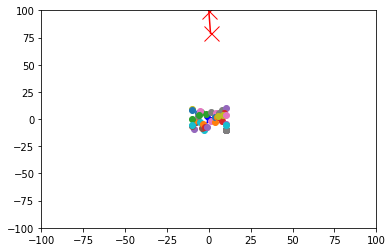

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 151


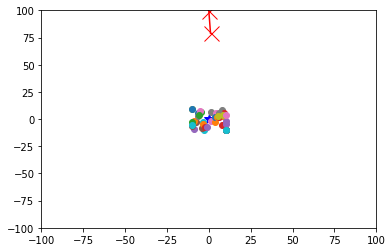

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 152


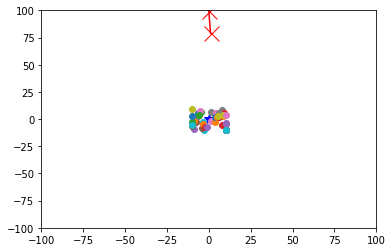

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 153


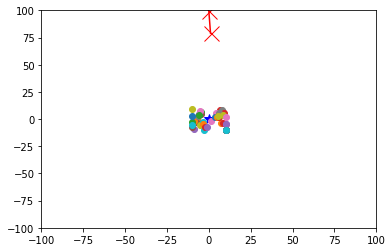

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 154


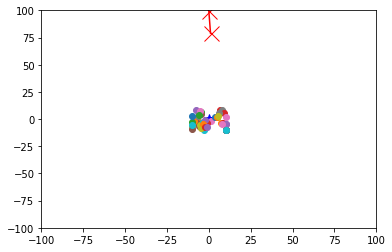

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 155


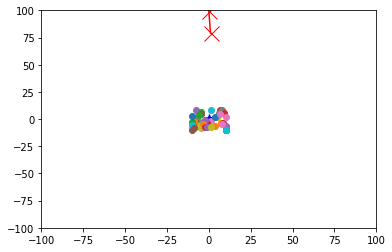

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 156


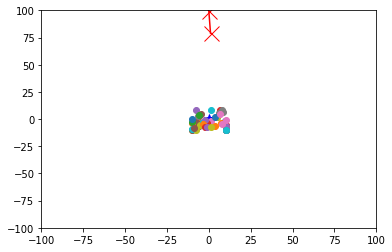

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 157


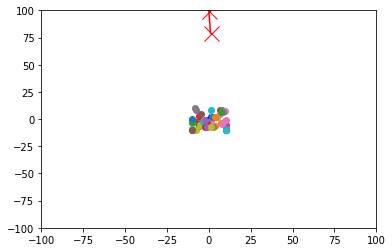

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 158


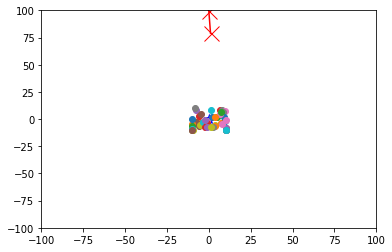

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 159


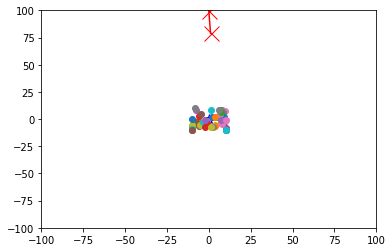

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 160


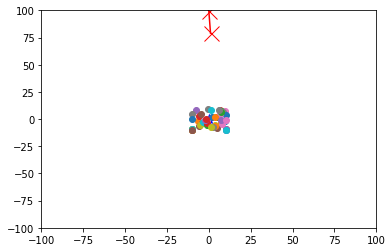

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 161


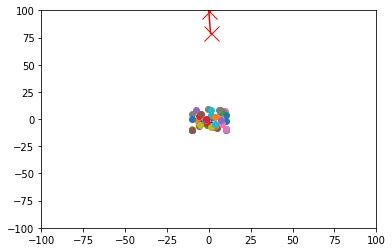

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 162


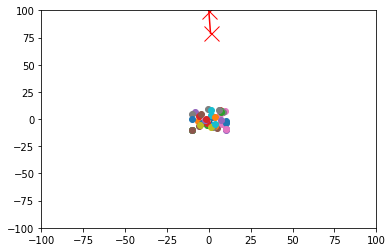

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 163


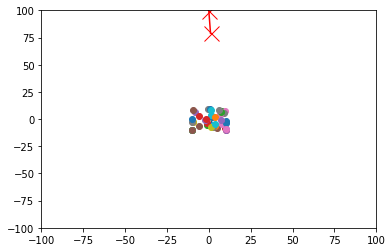

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 164


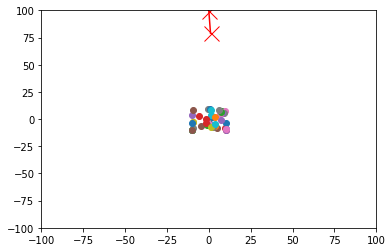

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 165


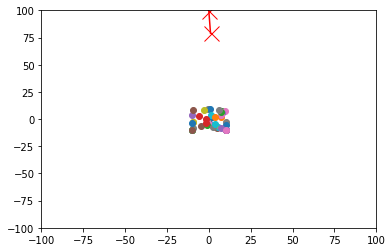

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 166


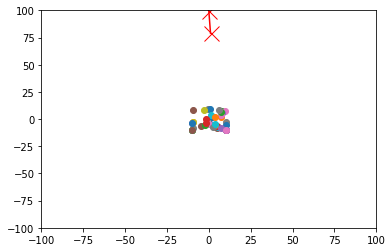

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 167


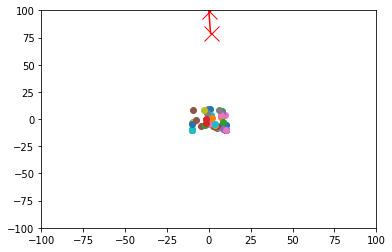

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 168


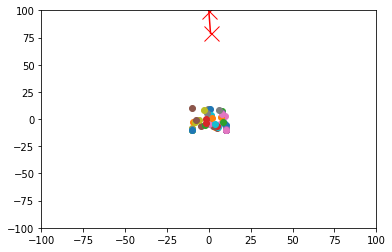

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 169


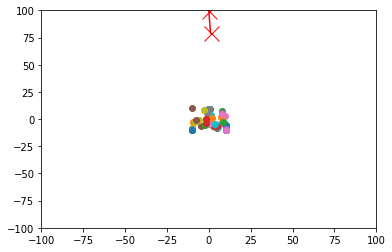

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 170


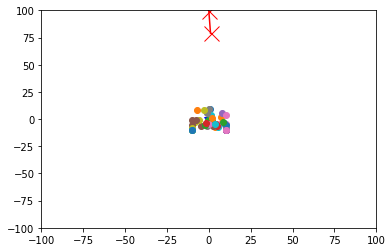

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 171


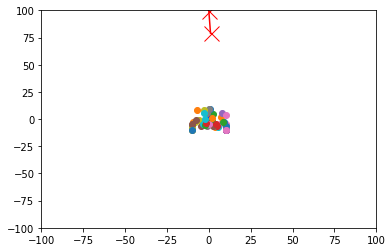

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 172


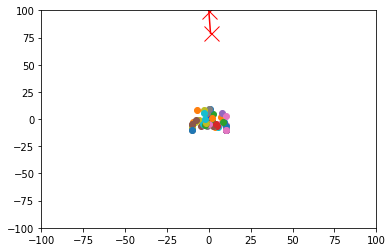

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 173


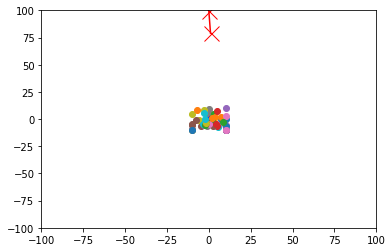

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 174


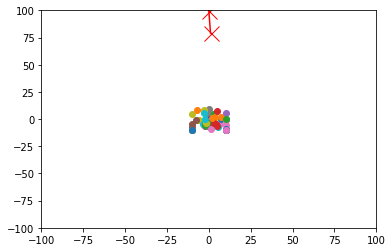

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 175


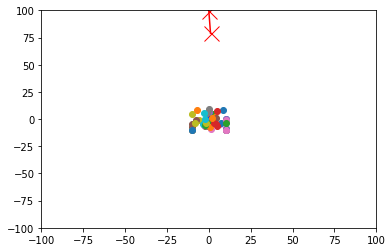

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 176


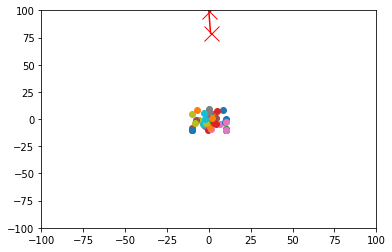

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 177


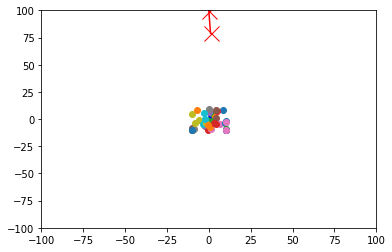

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 178


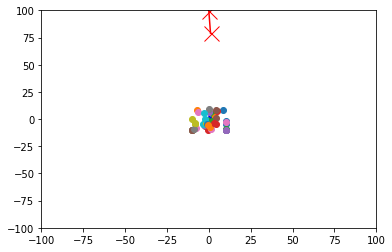

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 179


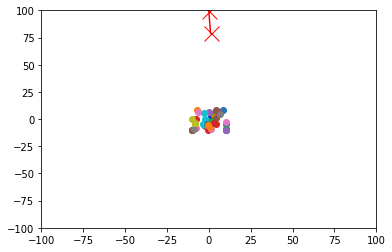

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 180


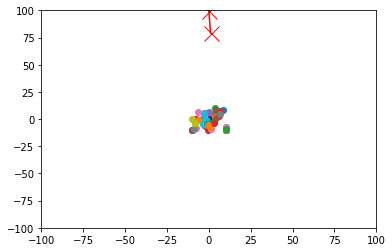

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 181


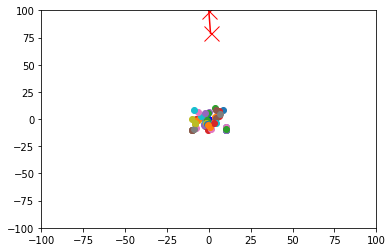

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 182


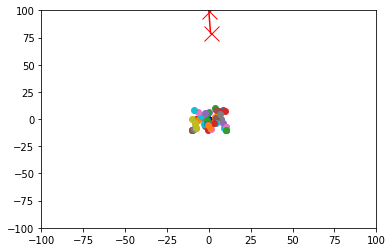

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 183


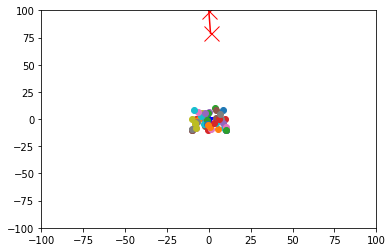

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 184


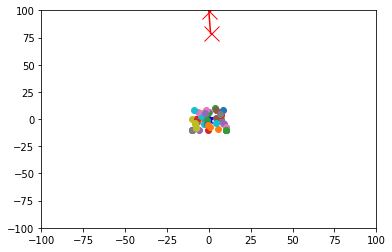

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 185


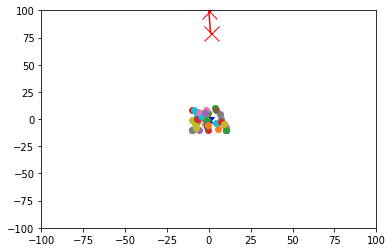

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 186


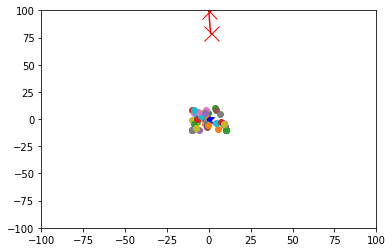

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 187


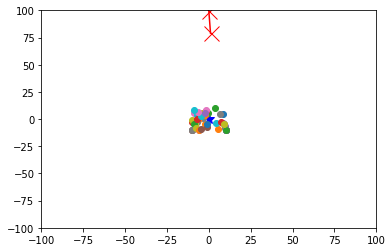

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 188


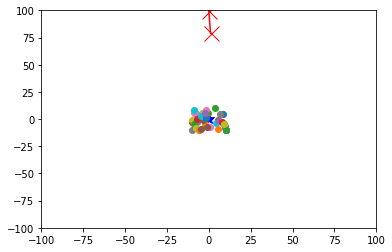

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 189


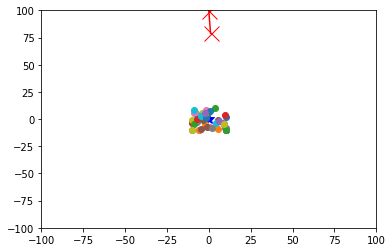

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 190


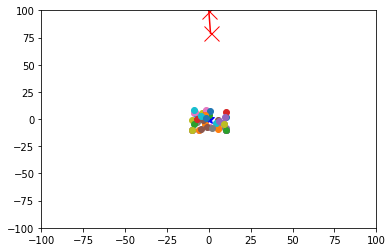

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 191


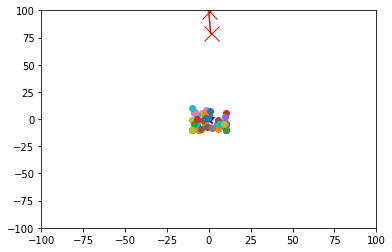

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 192


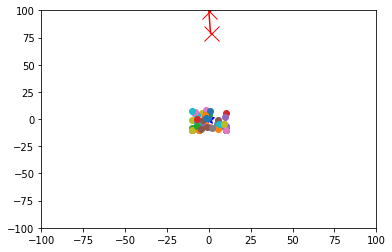

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 193


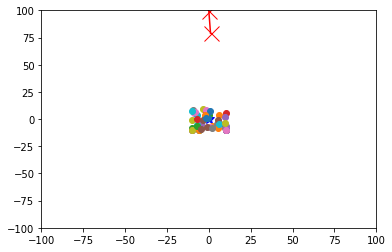

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 194


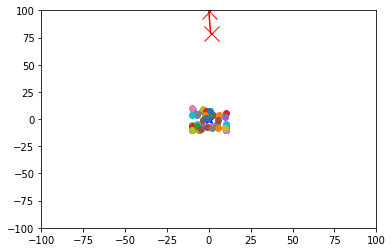

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 195


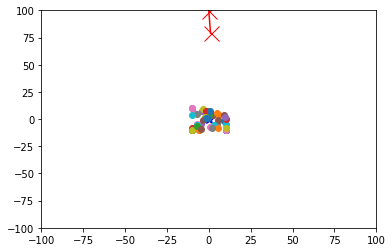

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 196


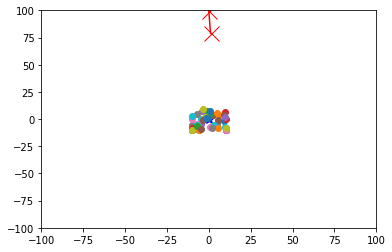

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 197


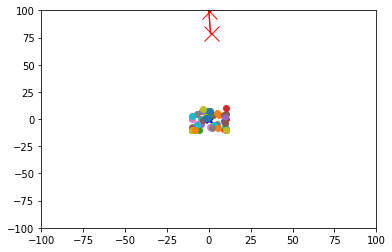

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 198


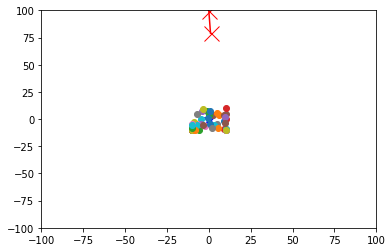

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 199


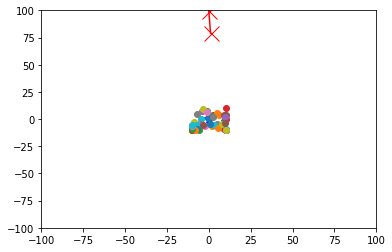

Melhor Ponto:  [99.14531762391144, 79.02744096958781]

Iteração: 200


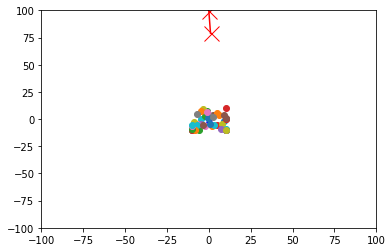

Melhor Ponto:  [99.14531762391144, 79.02744096958781]



In [ ]:
#otimizador ABC
melhor_posicao = None
ciclo = 0
#alocando as abelhas oportunistas como trabalhadoras em suas fontes
alocar_abelhas(trabalhadoras)
lista_melhores_valores = []
while ciclo < ITERACOES:
  print("Iteração: {:.0f}".format(ciclo+1))
  ciclo += 1
  for exploradora in exploradoras:
    #movimentando as trabalhadoras de cada fonte de comida
    for trabalhadora in exploradora.trabalhadoras:
      movimenta_abelha(trabalhadora)
    #obtem a melhor posição da iteração
    melhor_posicao_iter = None
    if len(exploradora.trabalhadoras) == 0:
      melhor_posicao_iter = exploradora.posicao
    for trabalhadora in exploradora.trabalhadoras:
      if melhor_posicao_iter is None or fitness(FCUSTO, trabalhadora.posicao) > fitness(FCUSTO, melhor_posicao_iter):
        melhor_posicao_iter = trabalhadora.posicao.copy()
    #atualiza posição atual da abelha exploradora
    if melhor_posicao_iter is not None and fitness(FCUSTO, melhor_posicao_iter) > fitness(FCUSTO, exploradora.posicao):
      exploradora.posicao = melhor_posicao_iter.copy()
      exploradora.ciclos_sem_melhora = 0
    else:
      exploradora.ciclos_sem_melhora += 1
    #desfaz a exploração da fonte de comida se necessário
    if exploradora.ciclos_sem_melhora >= CICLOS:
      exploradora.posicao = [random.uniform(-10, 10), random.uniform(-10, 10)]
      exploradora.melhor_posicao = exploradora.posicao.copy()
      exploradora.ciclos_sem_melhora = 0
      trabalhadoras_desalocadas = exploradora.trabalhadoras
      exploradora.trabalhadoras = []
      alocar_abelhas(trabalhadoras_desalocadas)
    #atuaiza melhor posicao global
    if melhor_posicao is None or fitness(FCUSTO, melhor_posicao_iter) > fitness(FCUSTO, melhor_posicao):
      melhor_posicao = melhor_posicao_iter.copy()
    lista_melhores_valores.append(melhor_posicao)
  #plota os eixos
  plt.axis([E1, E2, E1, E2])
  #ponto ideal
  plt.plot(0,0, marker='*', markersize=10, color='b')
  #exibe o enxame - mostrando no gráfico as posições atuais de cada abelha exploradora
  for i in range(FONTES_ALIMENTACAO):
    exploradora = exploradoras[i]
    #variáveis das DIMENSÕES do problema
    d1,d2 = zip(exploradora.posicao)
    plt.plot(d1,d2, marker='o')
  #ponto gbest
  plt.plot(melhor_posicao[0], marker='x', markersize=15, color='r')
  plt.show()
  print("Melhor Ponto: ", melhor_posicao)
  print("")

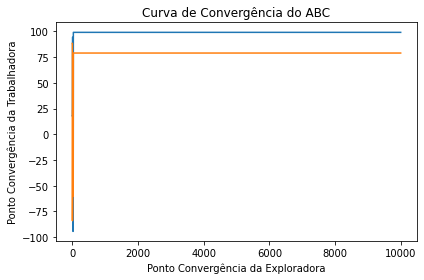

In [ ]:
#resultado
x = []
y = []
for i in range(len(lista_melhores_valores)):
  x.append(i)
  y.append(lista_melhores_valores[i])
plt.plot(x, y)
plt.title("Curva de Convergência do ABC")
plt.xlabel("Ponto Convergência da Exploradora")
plt.ylabel("Ponto Convergência da Trabalhadora")
plt.tight_layout()